[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six
import yaml

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels, filled=False, ret_image=False):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        image = draw_contours(image, masks[i], labels[i], filled)
    if ret_image:
        return image
    else:
        display_image(image)

def display_fluorescence(fluorescence, masks, labels, ret_image=False):
    image = cv2.cvtColor(scale_image(fluorescence), cv2.COLOR_GRAY2RGB)
    if fluorescence.max() == 1:  # if binary image
        sc, fc = {}, {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            image = draw_contours(image, combined_mask & fluorescence, k, filled=True)
            sc[k] = sum(combined_mask.flatten())
            fc[k] = sum((combined_mask & fluorescence).flatten())
        for k in sc:
            print("Class %s (%s): %i/%i (%.2f%%)" %
                  (k, colormap.colors[k], fc[k], sc[k], fc[k]*100/sc[k]))
    else:
        fig, axs = plt.subplots(1, len(np.unique(labels)), figsize=(18,5))
        intensities = scale_image(image_fluorescent, 100)
        fc = {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            axs[k].hist(intensities.flatten()[np.nonzero(combined_mask.flatten())],
                     bins=range(100), color = colormap.colors[k])
            axs[k].set_title("Class %i" % k)
            axs[k].set_xlim([0,100])
    if ret_image:
        return image
    else:
        display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = TSNE(learning_rate='auto', init='pca', random_state=0).fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def draw_contours(image, mask, color_label, filled=False):
    color = np.array(matplotlib.colors.to_rgb(colormap.colors[color_label]))*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    thickness = -1 if filled else 1
    return cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=thickness)

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    # POSSIBLE BUG, VERIFY THAT from_dict DOESN'T INFER WRONG TYPES
    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, param_path, verbosity=0):
    with open(param_path, 'r') as f:
        param_file = yaml.load(f, Loader=yaml.FullLoader)
        mode = param_file['mode']
        params = param_file['params']

    if verbosity:
        print("Using mode '%s'." % mode)
    
    if verbosity and params.get('clipLimit'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    # We are also deliberately not sharpening here
    if params.get('canny_unmasking'):
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, *params.get('canny_unmasking'))
        canny_filled = apply_imfill(apply_closure(canny, 5))
        
    ### IMAGE PREPROCESSING ###
    
    if params.get('invert_image'):
        image = 255 - image

    if params.get('denoise_pre'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params.get('contrast'):
        if verbosity:
            print(("Enhancing contrast by factor of %.2f, with "
                   "offset=%s and preserve_background=%s.") %
                  (params['contrast'], params['offset'], params['preserve_background']))
        image = apply_contrast(image, params['contrast'],
                               params['offset'], params['preserve_background'])
    
    if params.get('clipLimit'):
        if verbosity:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params.get('denoise_post'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])

    if verbosity and params.get('clipLimit'):
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])
    
    ### IMAGE BINARIZATION ###
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbosity:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbosity:
            print("Applying Canny with thresholds %i and %i." %
                  (params['canny_thresh1'], params['canny_thresh2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['canny_thresh1'], params['canny_thresh2'])
    elif mode == "edge_sobel":
        if verbosity:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbosity:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbosity:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_manual":
        if verbosity:
            print("Manually thresholding on values >=%i." % params['manual_threshold'])
        binarized = np.uint8(image >= params['manual_threshold'])
    elif mode == "thresh_otsu":
        if verbosity:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None

    ### IMAGE POSTPROCESSING ###
    
    if params.get('size_thresh'):
        if verbosity:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(binarized, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                binarized = binarized * (1 - np.uint8(labelled == i))
    
    if params.get('canny_unmasking'):
        if verbosity:
            print("Unmasking areas without edges using Canny%s:" % params.get('canny_unmasking'))
        binarized = binarized & canny_filled  # POSSIBLE BUG: CHECK IF CANNY_FILLED IS BINARY
        
    if params.get('closure_ks'):
        if verbosity:
            print("Closing with kernel size of %i." % params['closure_ks'])
        filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
        if verbosity >= 2:
            display_image_array([image, binarized, filled],
                                ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)
        return filled
    else:
        if verbosity >= 2:
            display_image_array([image, binarized],
                                ["Preprocessed", "Binarized"], columns=2, dpi=450)
        return binarized

# Extract mask from gray image

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 100.00, with offset=-11 and preserve_background=False.
Manually thresholding on values >=1.
Unmasking regions smaller than 25 pixels.
Unmasking areas without edges using Canny[130, 180]:
Closing with kernel size of 2.


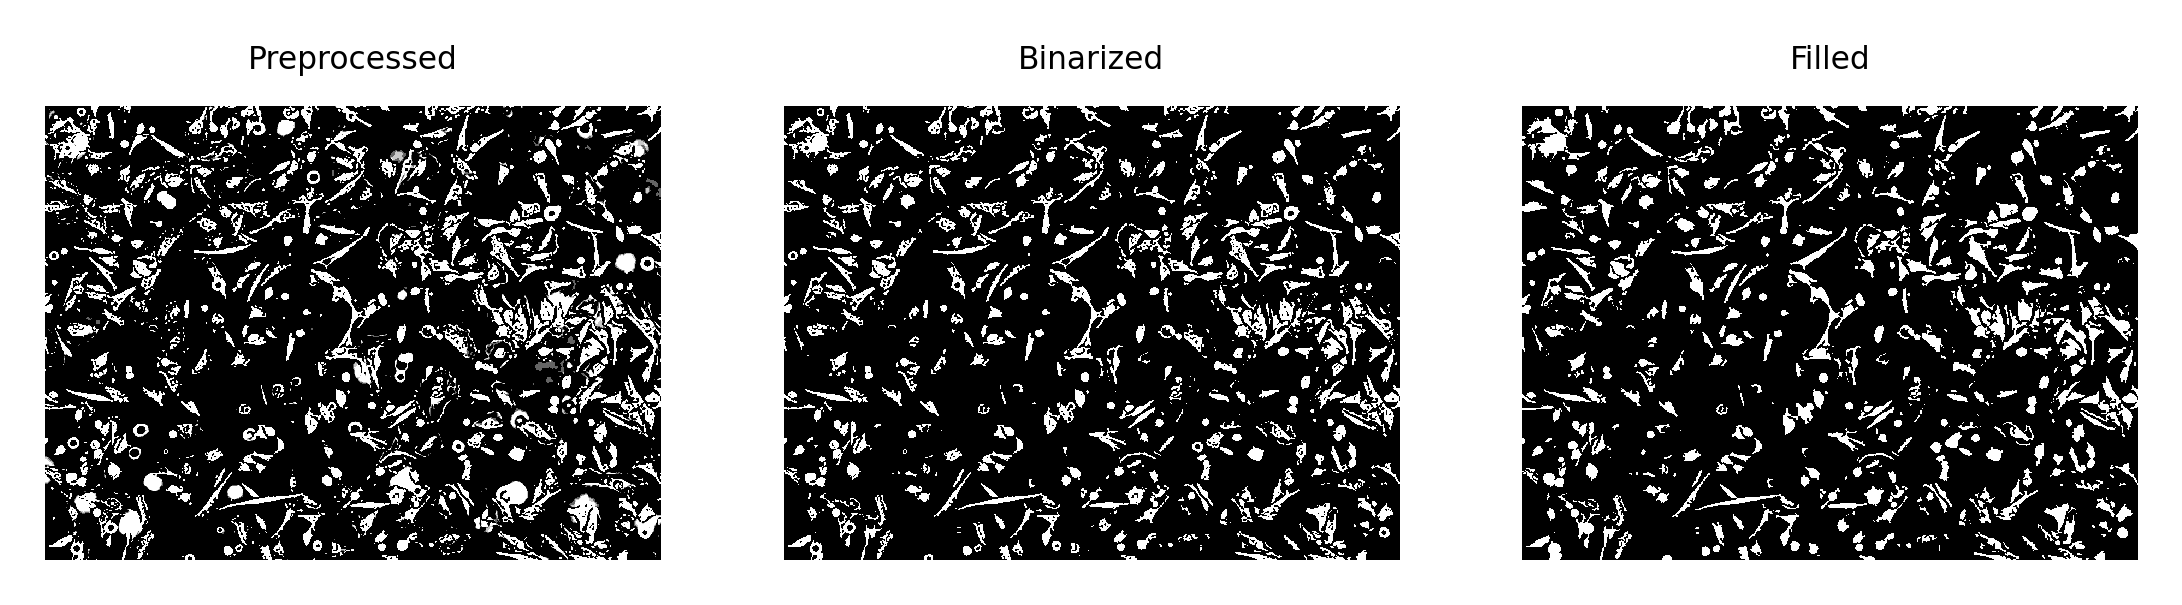

In [4]:
image_gray = cv2.imreadmulti('source_images/adherent_color-1.tiff',
                             flags=cv2.IMREAD_GRAYSCALE)[1][1]
image_gray = scale_image(image_gray)
mask_gray = get_mask_image(image_gray, 'params_gray_mask.yml', verbosity=2)

# Extract mask from fluorescent image

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 10.00, with offset=-12 and preserve_background=False.
Manually thresholding on values >=1.
Unmasking regions smaller than 25 pixels.
Closing with kernel size of 2.


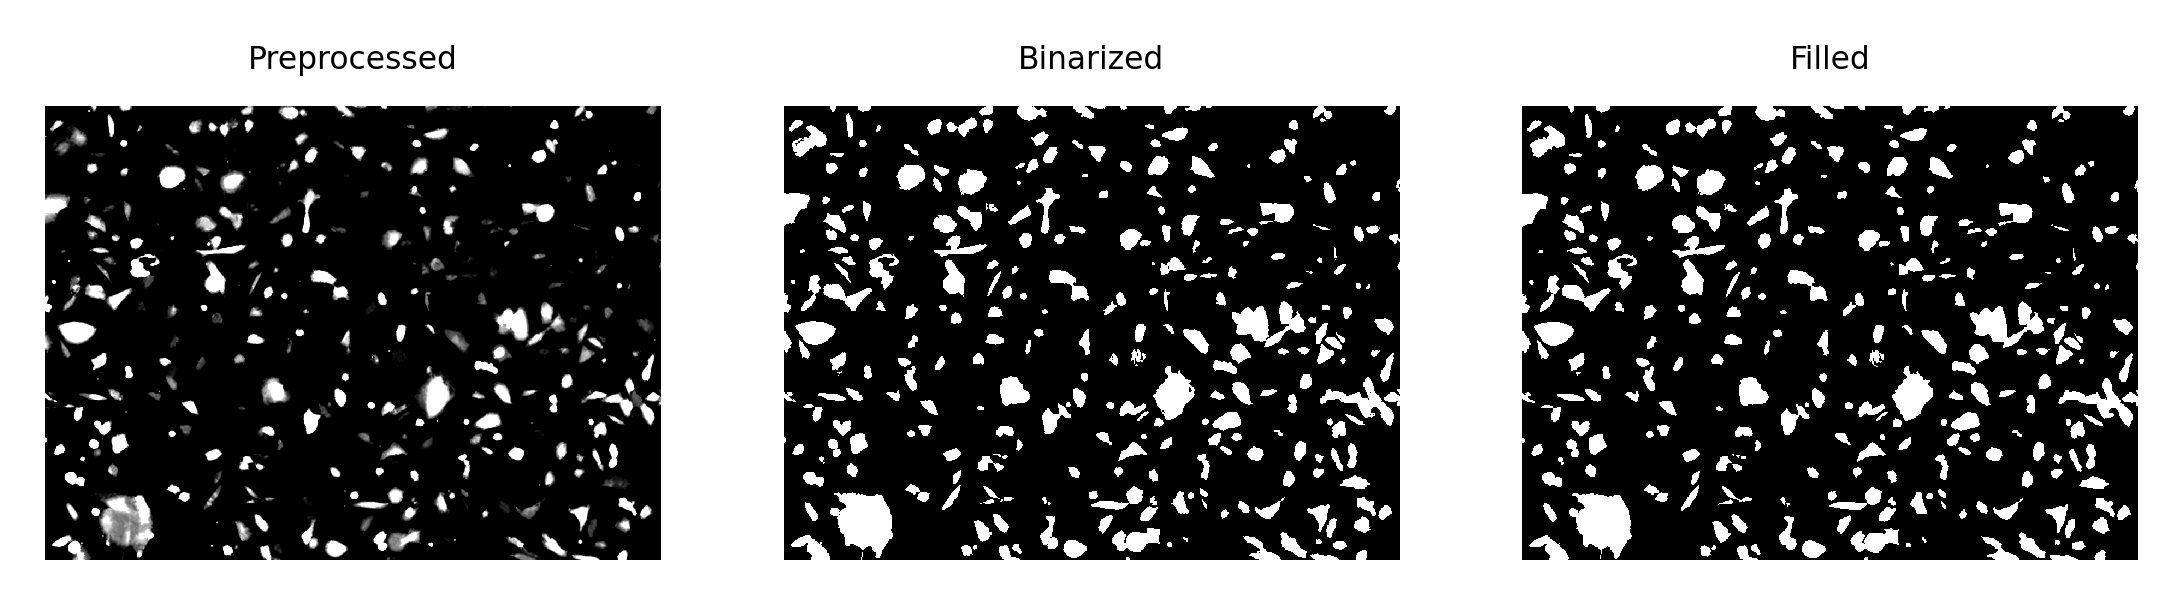

In [5]:
image_fluorescent = cv2.imreadmulti('source_images/adherent_color-1.tiff',
                                    flags=cv2.IMREAD_GRAYSCALE)[1][0]
image_fluorescent = scale_image(image_fluorescent)
mask_fluorescent = get_mask_image(image_fluorescent, 'params_fluorescent_mask.yml', verbosity=2)

# Merge masks, extract features, then scale and reduce dimensions

In [6]:
mask_image = mask_gray | mask_fluorescent
df, masks = extract_features(image_gray, mask_image)
display(df)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x    y                                                                    
91   7                       0.577056                         21.449830   
147  4                       0.486994                         26.670520   
278  35                      0.521130                         48.802708   
327  35                      0.695453                         65.247025   
371  9                       0.618944                         28.534893   
...                               ...                               ...   
406  819                     0.565273                         38.012297   
992  824                     0.358544                         59.016326   
1058 823                     0.735558                         22.751856   
265  827                     0.575807                         18.039533   
632  827                     0.249711                         30.061846   

         original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x    y                                                                   
91   7                 22.847319317591726                        174.5   
147  4                 25.709920264364882                        254.5   
278  35                 59.50630218724736                        715.5   
327  35                 63.56886030125127                       1160.5   
371  9                               30.0                        385.5   
...                                   ...                          ...   
406  819               44.294469180700204                        512.5   
992  824                65.37583651472461                        599.0   
1058 823                24.20743687382041                        286.5   
265  827                17.72004514666935                        141.5   
632  827               29.614185789921695                        162.5   

          original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x    y                                                                  
91   7                           12.377749          61.79898987322329   
147  4                           12.988394          73.79898987322332   
278  35                          25.432537         165.78174593052054   
327  35                          45.376229          260.8355697996835   
371  9                           17.661493          83.94112549695431   
...                                    ...                        ...   
406  819                         21.487328         115.59797974644673   
992  824                         21.159945          221.0954544295054   
1058 823                         16.735300          68.28427124746187   
265  827                         10.387281          48.72792206135785   
632  827                          7.506775          69.79898987322332   

         original_shape2D_PerimeterSurfaceRatio  \
x    y                                            
91   7                      0.35414893910156614   
147  4                       0.2899763845706221   
278  35                     0.23170055336201334   
327  35                       0.224761369926483   
371  9                       0.2177461102385326   
...                                         ...   
406  819                    0.22555703365160337   
992  824                     0.3691076033881559   
1058 823                     0.2383395156979472   
265  827                      0.344366940362953   
632  827                    0.42953224537368195   

          original_shape2D_PixelSurface  original_shape2D_Sphericity  \
x    y                                                                 
91   7                            175.0                     0.757742   
147  4                            255.0                     0.766299   
278  35                           716.0                     0.571970   
327  35                          1161.0                     0.462978   
371  9                   

In [7]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

scaled = scaler.fit_transform(df.to_numpy(dtype=np.float64))
reduced = pca.fit_transform(scaled)
df = pd.DataFrame(reduced, index=df.index)

display(df)

0         1         2         3         4         5   \
x    y                                                                 
91   7   -6.282461 -1.194107 -1.591862 -1.317685  1.384948  0.616640   
147  4    5.943224  0.298734 -1.174290 -3.214444 -1.034753  1.729190   
278  35   1.346463  4.459712 -2.768220 -2.178127  0.578836  0.989785   
327  35  -3.312964  5.607195 -1.987374  0.503990 -0.038286 -0.226289   
371  9    2.836228 -1.190360 -1.550389 -1.085585 -0.379540 -2.233473   
...            ...       ...       ...       ...       ...       ...   
406  819 -0.583669  0.640655 -2.649308 -0.397361  0.492391 -1.576160   
992  824  4.429836  1.505149 -1.725775 -0.452696 -0.849815 -0.252820   
1058 823  0.200603 -1.161825 -2.300790 -1.831331  0.460333 -2.852821   
265  827 -2.565840 -4.485060  2.336439 -1.061533  0.254461 -2.217455   
632  827  4.384387 -3.521446 -2.410584 -0.015325  0.782083 -0.520696   

                6         7         8         9   ...        87        88  \
x    y                                            ...                       
91   7   -1.402438  0.392375 -0.132470  0.053527  ...  0.023413 -0.012998   
147  4    0.301034  1.071278  0.126386  0.124957  ...  0.000380  0.001034   
278  35   0.306673  0.750359  1.455123  0.784540  ... -0.001519 -0.007294   
327  35   0.755380  0.279959  0.580608  0.617986  ...  0.006238  0.008438   
371  9   -0.000630  0.665289 -0.464549  0.545581  ...  0.012589  0.013139   
...            ...       ...       ...       ...  ...       ...       ...   
406  819  0.044523  0.137326 -1.133552  0.629727  ... -0.005204  0.008123   
992  824 -0.004108 -0.674241  0.819954 -1.161118  ...  0.006433 -0.025145   
1058 823 -0.428451  1.184048 -0.081996  0.429533  ...  0.009881 -0.002481   
265  827  5.466382  1.628720 -1.078586 -1.541586  ... -0.006091 -0.025751   
632  827 -0.630576  0.366210  0.628592 -0.630301  ...  0.009063 -0.008191   

                89        90        91        92        93        94  \
x    y                                                                 
91   7    0.019894 -0.012806 -0.020382  0.011952  0.005277  0.004165   
147  4   -0.008974 -0.004679 -0.016134  0.002487 -0.005045 -0.000092   
278  35   0.003848 -0.004908 -0.004409  0.003017  0.006373 -0.000150   
327  35  -0.019368 -0.003043 -0.004459 -0.003290  0.001482  0.000692   
371  9    0.006917 -0.002555 -0.001808 -0.005801  0.007160  0.002135   
...            ...       ...       ...       ...       ...       ...   
406  819  0.001004 -0.007925  0.002642 -0.005021 -0.000293  0.000883   
992  824  0.008739 -0.001852  0.009646 -0.004186 -0.004190  0.001537   
1058 823  0.006854 -0.000535  0.000802  0.001027  0.000902 -0.002189   
265  827 -0.002525 -0.001118 -0.015038  0.004825  0.000600 -0.004151   
632  827  0.008055  0.007192  0.000646 -0.003391  0.001207  0.003994   

                    95        96  
x    y                            
91   7    5.440616e-07 -0.000132  
147  4   -7.408118e-05 -0.000007  
278  35  -7.755140e-05  0.000036  
327  35  -2.188367e-04  0.000027  
371  9   -8.973998e-07 -0.000026  
...                ...       ...  
406  819  6.314344e-05 -0.000022  
992  824 -4.572970e-04  0.000010  
1058 823 -5.244920e-07  0.000048  
265  827 -1.456461e-04 -0.000009  
632  827  3.403364e-05 -0.000046  

[319 rows x 97 columns]

# Determine number of clusters

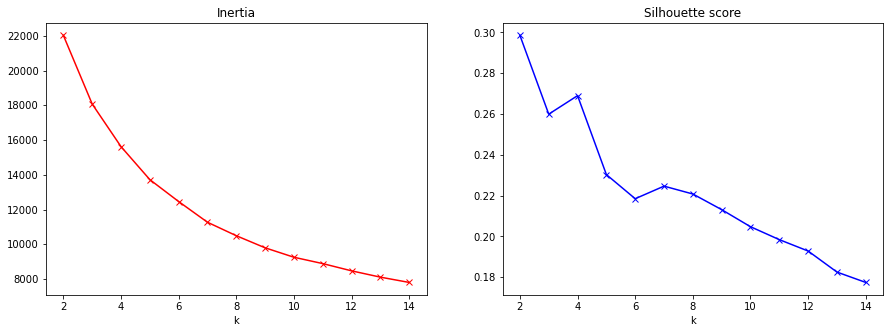

In [8]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

## User-defined values

In [9]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

# Fit and classify using k-means

In [10]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 50 (15.67%)
Class 1 (red): 138 (43.26%)
Class 2 (cyan): 119 (37.30%)
Class 3 (orange): 12 (3.76%)


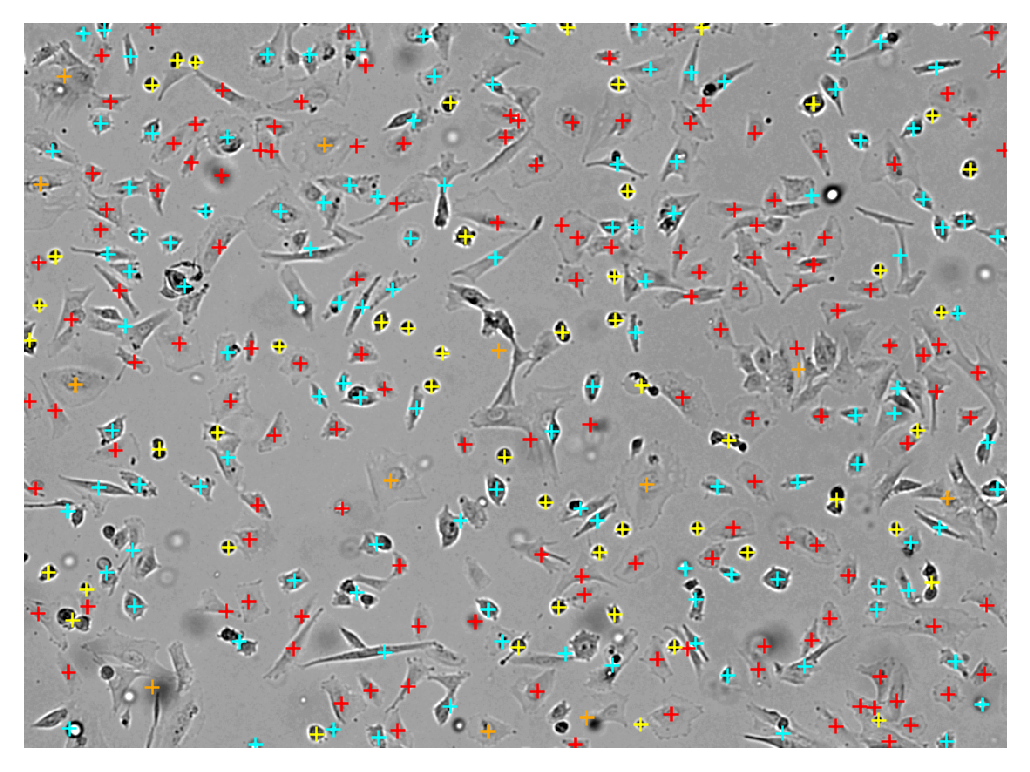

In [11]:
display_classifications(image_gray, df.index, labels)

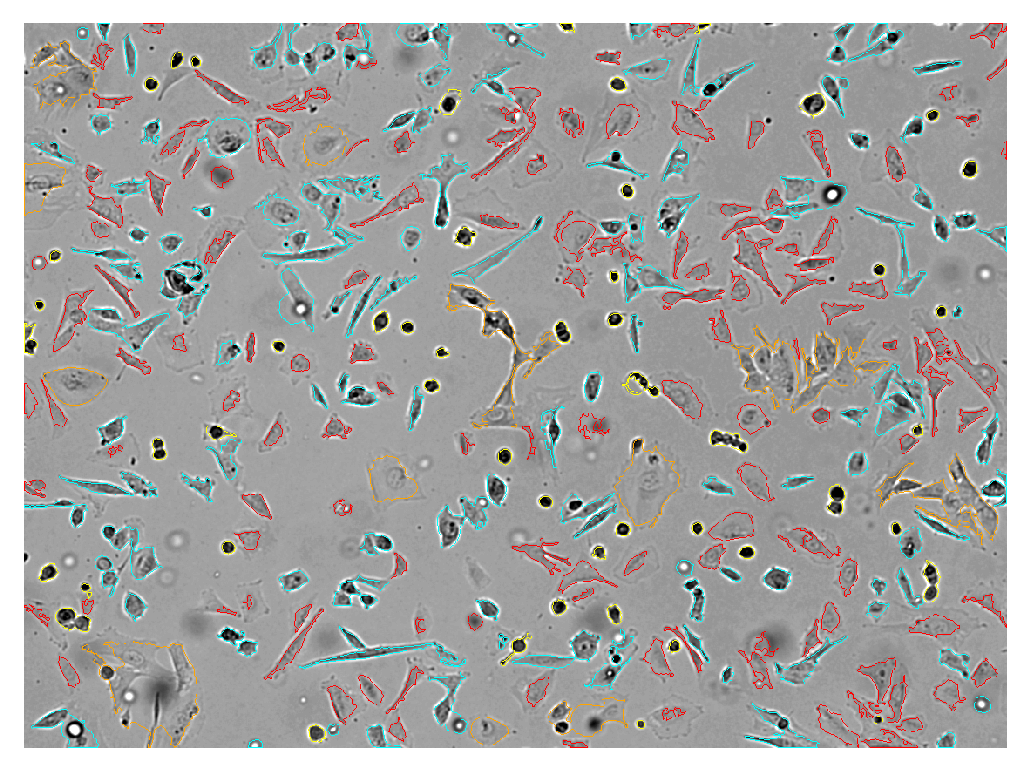

In [12]:
display_contours(image_gray, masks, labels)

Class 0, with 50 ROIs:


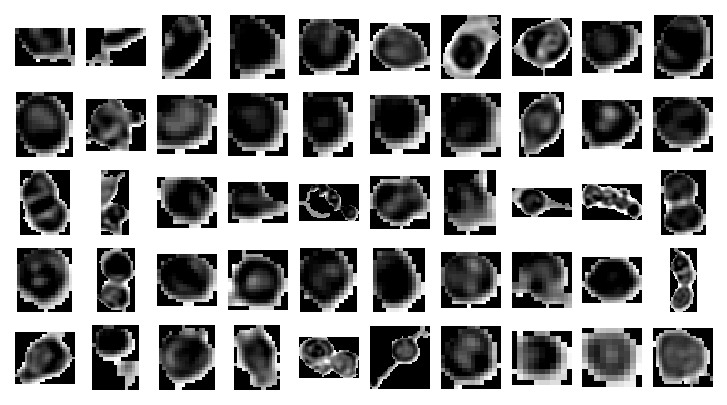

Class 1, with 138 ROIs:


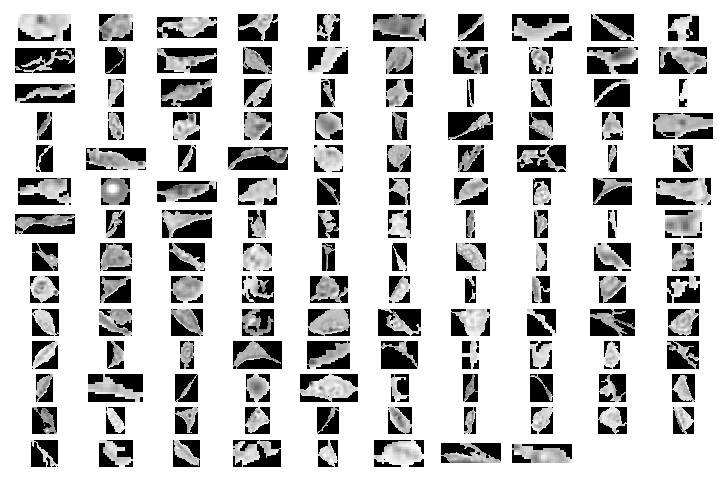

Class 2, with 119 ROIs:


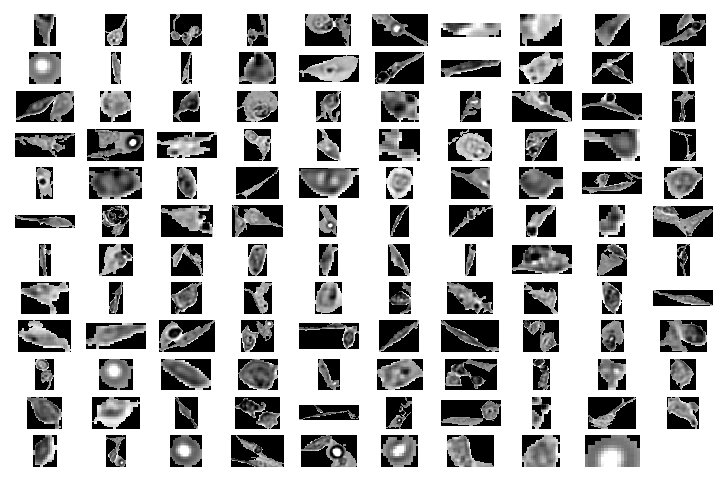

Class 3, with 12 ROIs:


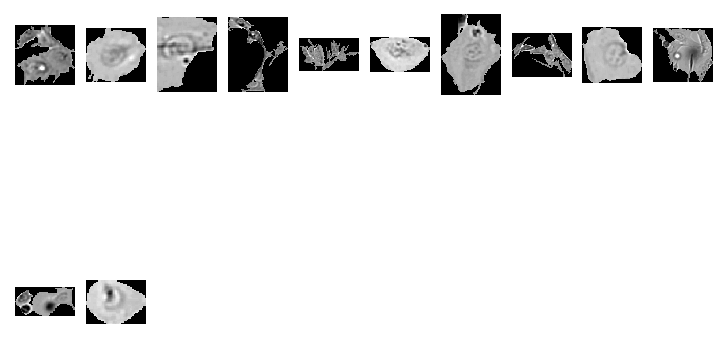

In [13]:
display_rois(image_gray, masks, labels)

# Visualize clusters with t-SNE

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


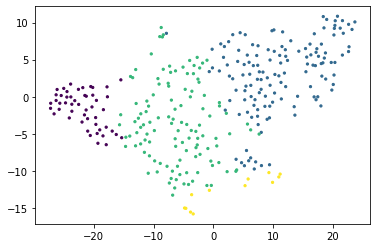

In [14]:
display_tsne(df)

# Quantify fluorescence within clusters

## Binary analysis

In [15]:
fluorescence_binarized = \
    get_mask_image(image_fluorescent, 'params_fluorescence.yml', verbosity=1)

Using mode 'thresh_manual'.
Denoising with intensity 3.
Enhancing contrast by factor of 10.00, with offset=-3 and preserve_background=False.
Manually thresholding on values >=1.


Class 0 (yellow): 11183/12700 (88.06%)
Class 1 (red): 50680/62381 (81.24%)
Class 2 (cyan): 66689/80057 (83.30%)
Class 3 (orange): 41678/43737 (95.29%)


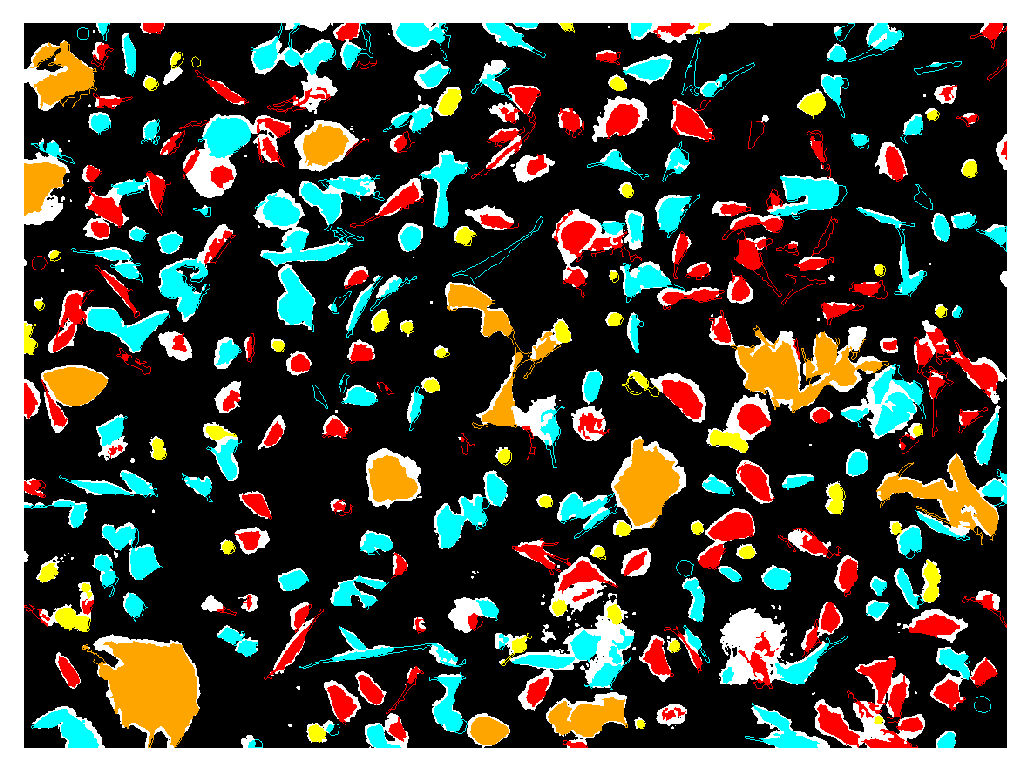

In [16]:
display_fluorescence(fluorescence_binarized, masks, labels)

## Intensity analysis

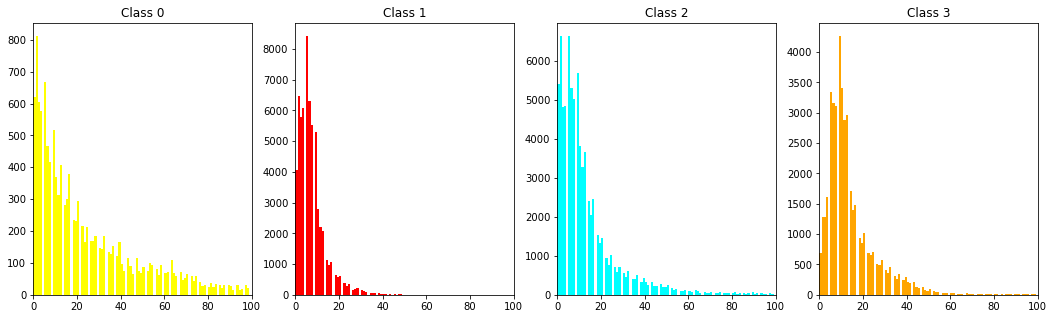

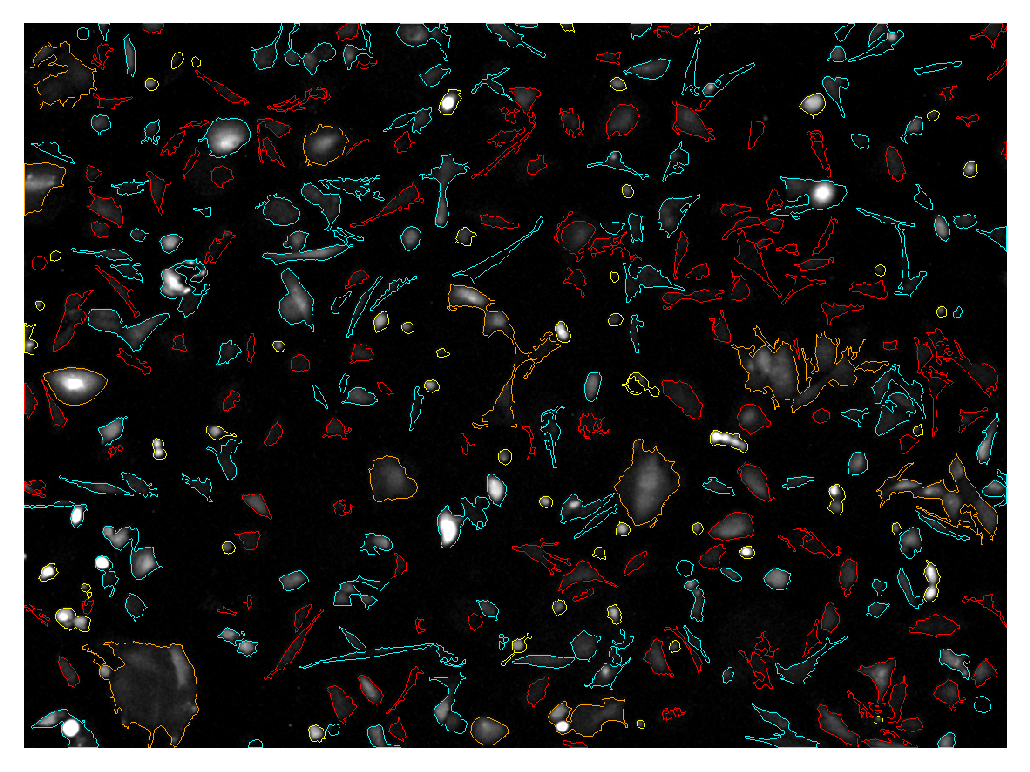

In [17]:
display_fluorescence(image_fluorescent, masks, labels)

## Class-wise analysis

Class 0


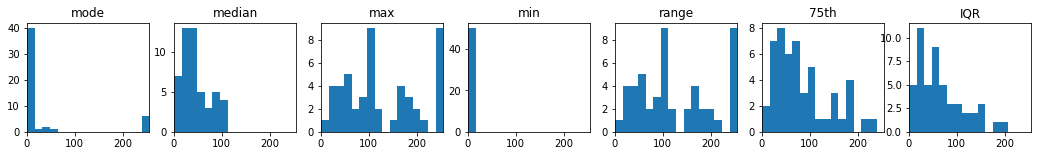

Class 1


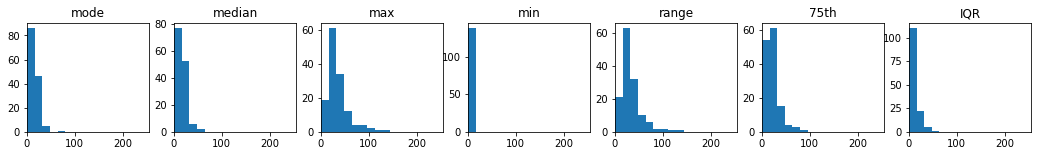

Class 2


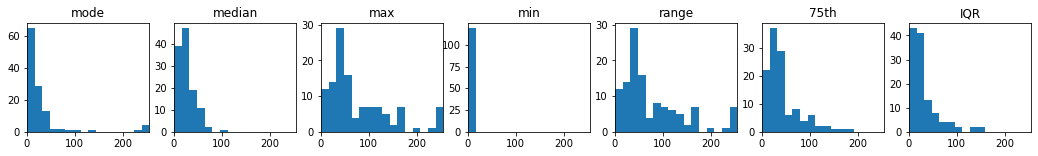

Class 3


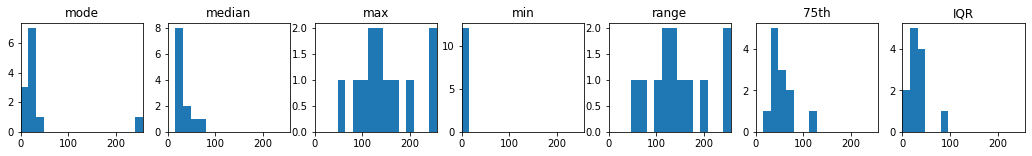

In [18]:
statistics = [[]] * len(np.unique(labels))

column_labels = ["mode", "median", "max", "min", "range", "75th", "IQR"]

for i in range(len(masks)):
    intensities = image_fluorescent.flatten()[np.argwhere(masks[i].flatten()).flatten()]
    s, c = np.unique(intensities, return_counts=True)
    # can't use += here, will cause wonky behavior
    statistics[labels[i]] = statistics[labels[i]] + \
                            [[s[np.argmax(c)],  # returns the first mode
                             np.median(intensities),
                             np.max(intensities),
                             np.min(intensities),
                             np.max(intensities) - np.min(intensities),
                             np.percentile(intensities, 75),
                             np.percentile(intensities, 75) - np.percentile(intensities, 25)],]
    
for i in range(len(statistics)):
    # must convert to numpy array before passing to pandas, or will infer wrong types
    statistics[i] = pd.DataFrame(np.array(statistics[i]),
                                 columns=column_labels)
    
    print("Class %i" % i)
    fig, axs = plt.subplots(1, len(column_labels), figsize=(18,2))
    for j in range(len(column_labels)):
        c = column_labels[j]
        axs[j].hist(statistics[i][c], bins=16, range=(0,256))
        axs[j].set_title(c)
        axs[j].set_xlim([0,256])
    plt.show()

### Kruskal-Wallis H tests

In [19]:
for c in column_labels:
    try:
        print("%s:\tpvalue=%s" % (c, stats.kruskal(*[k[c].values for k in statistics])[1]))
    except ValueError:
        print("%s:\tvalues identical" % c)
        continue
    for i in range(len(statistics)):
        for j in range(i+1, len(statistics)):
            try:
                pval = stats.kruskal(statistics[i][c].values, statistics[j][c].values)[1]
            except ValueError:
                print("  %i,%i:\tvalues identical" % (i, j))
                continue
            if pval >= 0.05:
                print("  %i,%i:\tpvalue=%.10f" % (i, j, pval))

mode:	pvalue=0.0017404036487390284
  1,2:	pvalue=0.2294018047
median:	pvalue=2.941026476517124e-14
  0,3:	pvalue=0.2882859865
max:	pvalue=1.0695710909063937e-23
  0,3:	pvalue=0.2211698611
min:	pvalue=0.006954663759345537
  0,1:	pvalue=0.7203488321
  0,3:	pvalue=0.1015526442
range:	pvalue=4.49591669289488e-24
  0,3:	pvalue=0.2392479829
75th:	pvalue=1.9964854438694428e-20
  0,3:	pvalue=0.1754249112
IQR:	pvalue=2.2110795357498562e-26
  2,3:	pvalue=0.0822372382


# Classify whole image stack

Image 0:


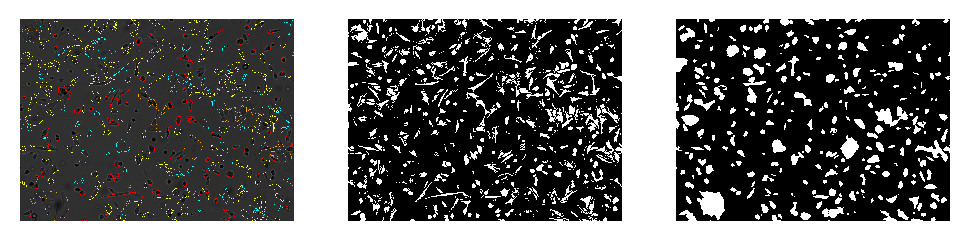

Image 1:


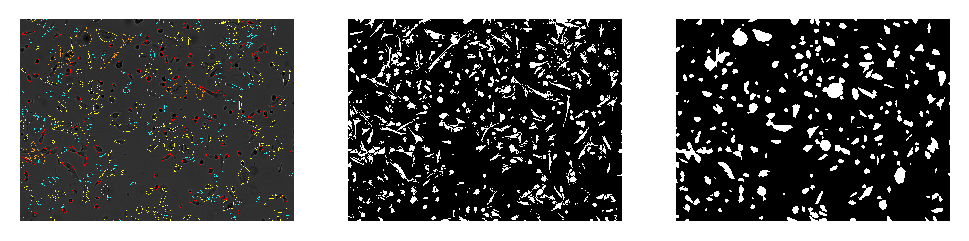

Image 2:


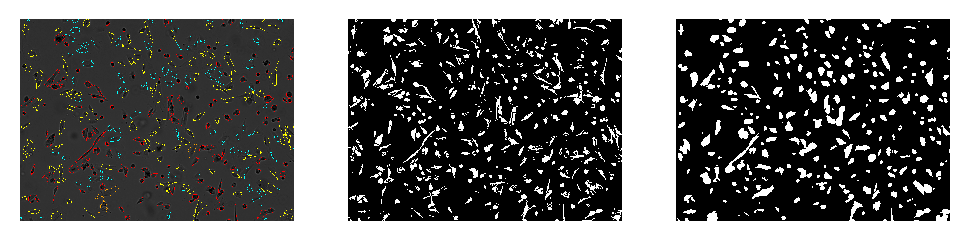

Image 3:


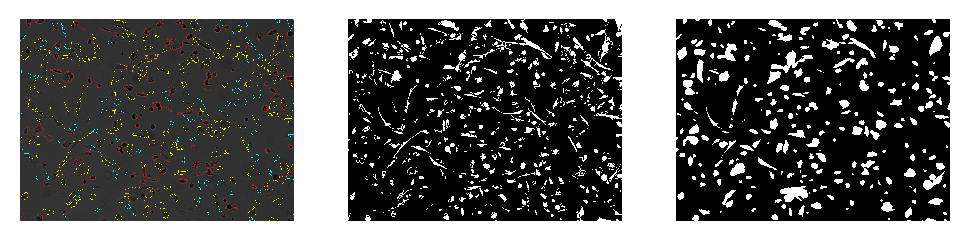

Image 4:


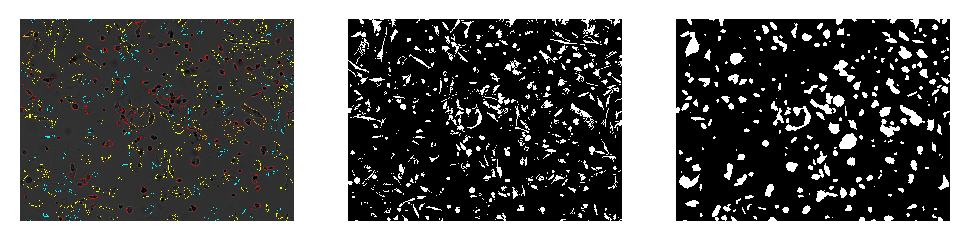

Image 5:


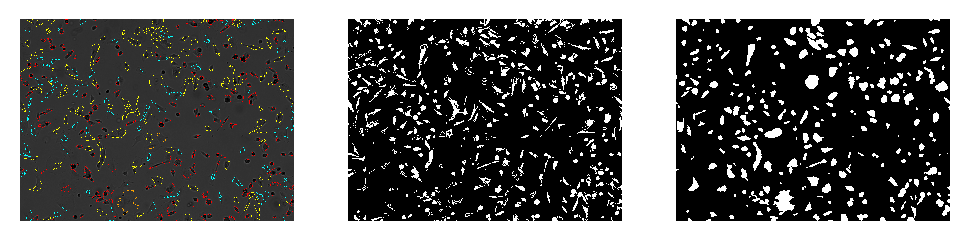

Image 6:


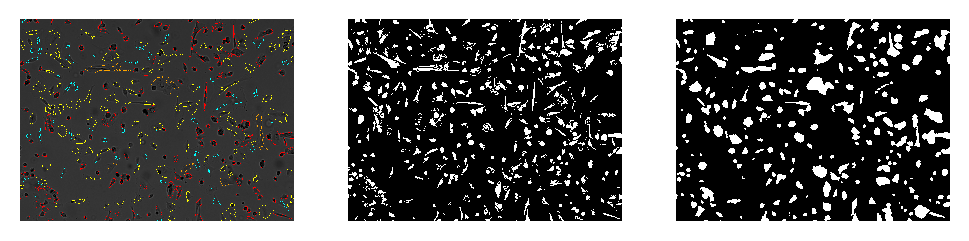

Image 7:


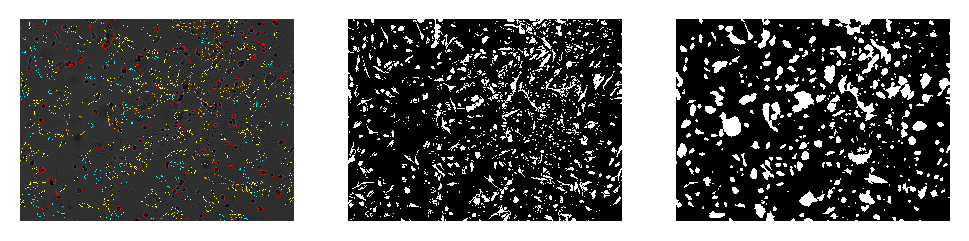

Image 8:


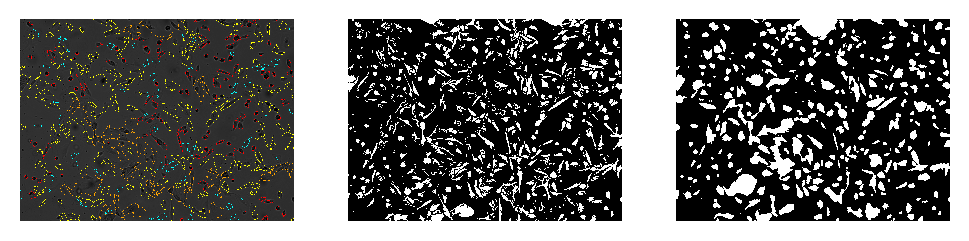

Image 9:


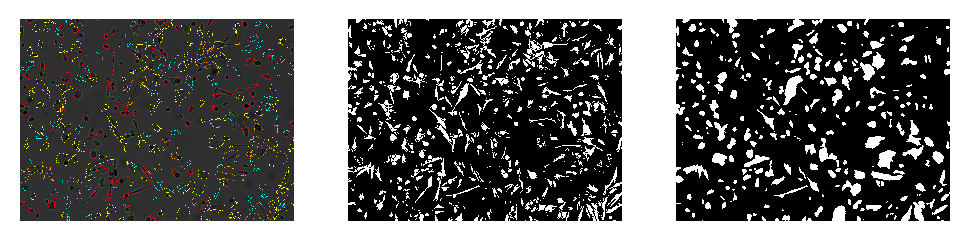

Image 10:


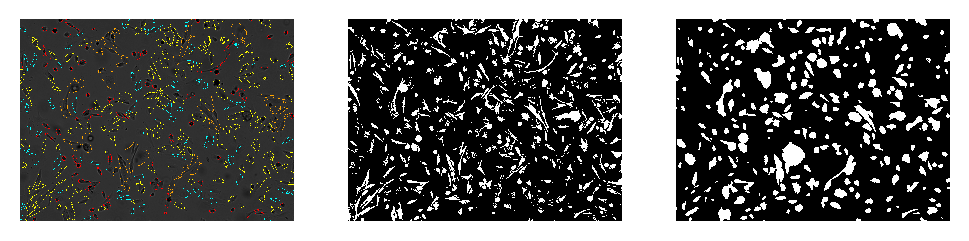

Image 11:


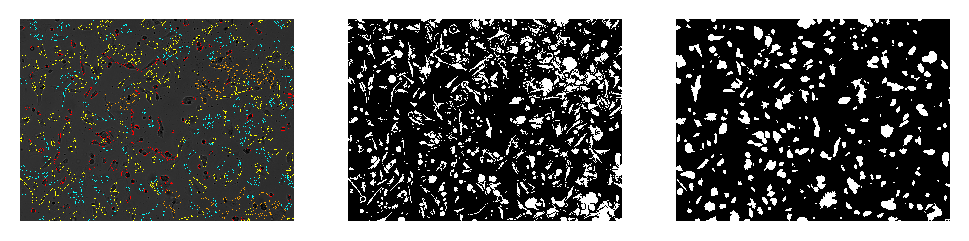

Image 12:


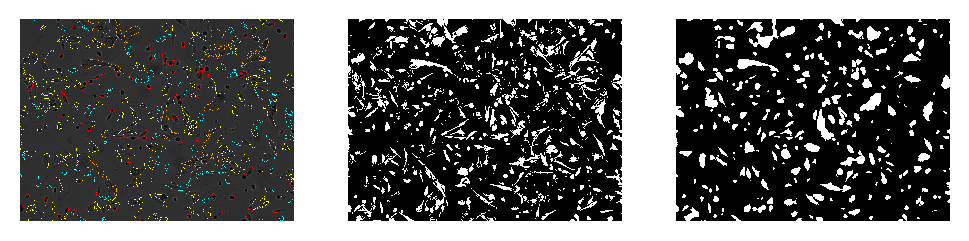

Image 13:


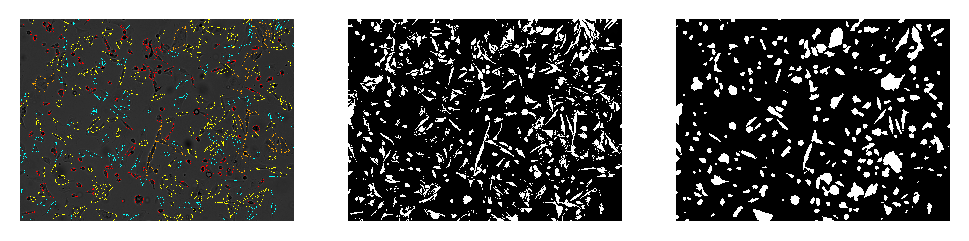

Image 14:


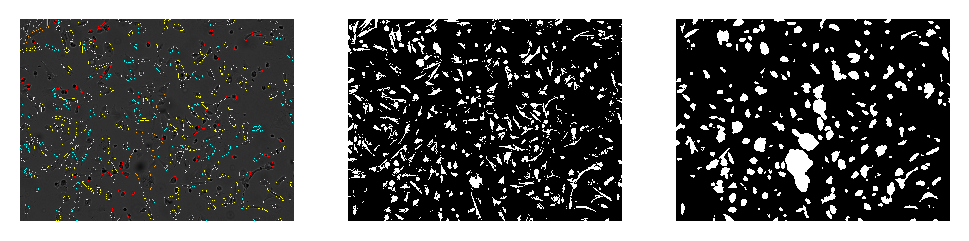

Image 15:


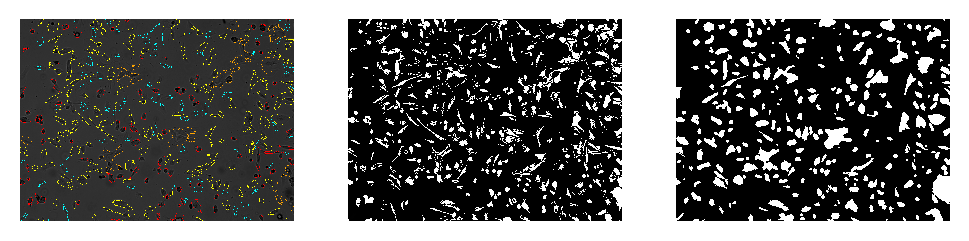

In [20]:
image_stack = cv2.imreadmulti('source_images/adherent_color-1.tiff',
                              flags=cv2.IMREAD_GRAYSCALE)[1]

scaler = StandardScaler()
pca = PCA(n_components='mle')
kmeans = KMeans(n_clusters=k, random_state=0)

counts = []

for i in range(0, len(image_stack), 2):
    image_fluorescent = image_stack[i]
    image_gray = image_stack[i+1]
    
    # Extract mask -> features
    mask_fluorescent = get_mask_image(scale_image(image_fluorescent),
                                      'params_fluorescent_mask.yml')
    mask_gray = get_mask_image(scale_image(image_gray), 'params_gray_mask.yml')
    mask_image = mask_gray | mask_fluorescent
    df, masks = extract_features(image_gray, mask_image)
    
    # Preprocess features
    if i == 0:
        scaled = scaler.fit_transform(df.to_numpy(dtype=np.float64))
        reduced = pca.fit_transform(scaled)
    else:
        scaled = scaler.transform(df.to_numpy(dtype=np.float64))
        reduced = pca.transform(scaled)
    df = pd.DataFrame(reduced, index=df.index)
    
    # Cluster using k-means
    if i == 0:
        kmeans.fit(df)
    labels = kmeans.predict(df)
    
    # Display sanity check images
    print("Image %i:" % (i/2))
    counts += [[a[1] for a in sorted(Counter(labels).items(), key=lambda a: a[0])],]
    contour_image = display_contours(image_gray, masks, labels, ret_image=True)
    display_image_array([contour_image, mask_gray, mask_fluorescent], columns=3, dpi=200)

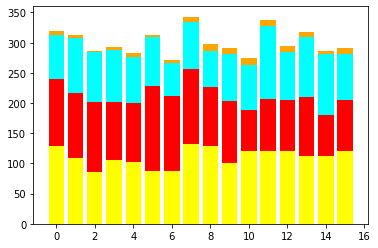

In [21]:
bottom = np.zeros(len(counts))
class_counts = np.array(counts).T

for i in range(len(class_counts)):
    c = class_counts[i]
    plt.bar(range(len(c)), c, bottom=bottom, color=colormap.colors[i])
    bottom += c